In [2]:
import requests
import numpy as np
import pandas as pd
import regex
import pycountry
import json
import matplotlib.pyplot as plt

In [3]:
wikidata = pd.read_csv("data\wikidata25k.csv")
wikidata["genders"].unique()

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\brief\AppData\Local\Temp\ipykernel_20016\3610291600.py:1: SyntaxWarning: invalid escape sequence '\w'
  wikidata = pd.read_csv("data\wikidata25k.csv")


array(['female', 'male', 'trans man', 'trans woman', 'transgender',
       'intersex', 'agender', 'non-binary', 'undisclosed gender'],
      dtype=object)

C:\Users\brief\AppData\Local\Temp\ipykernel_20016\690299487.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = genderCount[i]
C:\Users\brief\AppData\Local\Temp\ipykernel_20016\690299487.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pct = genderStat[i]


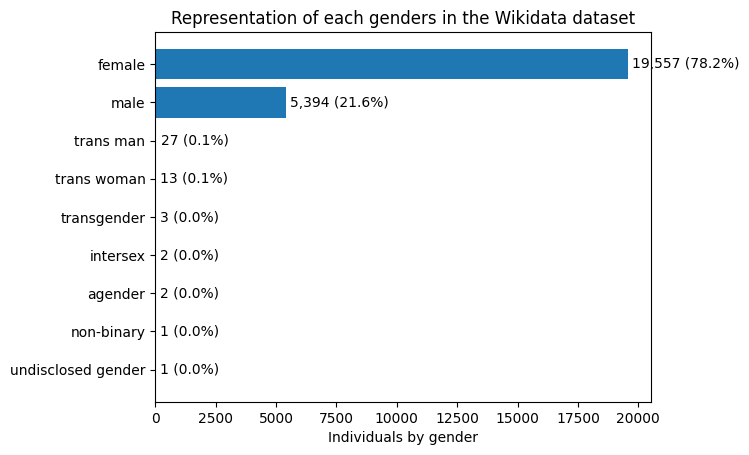

In [14]:
genderCount = wikidata["genders"].value_counts()
genderStat = (genderCount / wikidata["genders"].count()) * 100
genderLabel = wikidata["genders"].unique()

fig, ax = plt.subplots()
bars = ax.barh(np.arange(len(genderLabel)), genderCount)
ax.set_yticks(np.arange(len(genderLabel)), labels=genderLabel)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Individuals by gender')
ax.set_title('Representation of each genders in the Wikidata dataset')

for i, bar in enumerate(bars):
    count = genderCount[i]
    pct = genderStat[i]
    ax.text(
        bar.get_width() + max(genderCount) * 0.01,  # little offset from bar end
        bar.get_y() + bar.get_height() / 2,         # vertically centered
        f"{count:,} ({pct:.1f}%)",                  # format: "123 (45.6%)"
        va='center'
    )

plt.show()

In [15]:
wikidata.head()

,person,person_label,genders,dobs,countries,continents
0,http://www.wikidata.org/entity/Q10000001,Tatyana Kolotilshchikova,female,1937-04-11T00:00:00Z,Russia|Soviet Union,Europe|Asia
1,http://www.wikidata.org/entity/Q1000002,Claus Hammel,male,1932-12-04T00:00:00Z,Germany,Europe
2,http://www.wikidata.org/entity/Q1000006,Florian Eichinger,male,1971-07-14T00:00:00Z,Germany,Europe
3,http://www.wikidata.org/entity/Q10000101,Eliška Hladilová,female,1993-01-23T00:00:00Z,Czech Republic,Europe
4,http://www.wikidata.org/entity/Q100001260,Henk Rigters,male,1915-10-06T00:00:00Z,Kingdom of the Netherlands,Europe
